In [1]:
# import necessary library
from time import time
import numpy as np
import pandas as pd
from IPython.display import display

from scipy.stats import entropy
import os
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit


import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [2]:
dftrain = pd.read_pickle('data_train.p')
dftest = pd.read_pickle('data_test.p')

In [4]:
extra_columns = ['business_id', 
                 'date', 
                 'text', 
                 'user_id', 
                 'BestNights']
dummy_cols = ['NoiseLevel', 'WiFi', 'Smoking', 'AgesAllowed']
target = 'stars'

In [5]:
def data_to_model(raw_data, dummy_cols, extra_columns, normalize_using=None):
    df_X = raw_data.drop(extra_columns + dummy_cols + [target], axis=1)
    if normalize_using is not None:
        df_norm = normalize_using.drop(extra_columns + dummy_cols + [target], axis=1)
    df_y = raw_data[target]
    
    for dummy_col in dummy_cols:
        df_dummy = pd.get_dummies(raw_data[dummy_col], prefix=dummy_col)
        df_X = df_X.join(df_dummy)
        if normalize_using is not None:
            norm_dummy = pd.get_dummies(normalize_using[dummy_col], prefix=dummy_col)
            df_norm = df_norm.join(norm_dummy)
        
    if normalize_using is None:
        df_norm = df_X
        
    normalize(df_X, df_norm)
    return df_X.fillna(0), df_y


def normalize(df_X, normalize_using):
    # memory saving normalization
    for col in df_X.columns:
        # print('normalizing %s' % col)
        norm_mean = np.mean(normalize_using[col].astype(float))
        norm_std = np.std(normalize_using[col].astype(float))
        df_X[col] = (df_X[col].astype(float) - norm_mean) / norm_std
        
        
def mse_loss(preds, truths):
    assert len(preds) == len(truths)
    sse = 0.
    for i in range(len(preds)):
        sse += (preds[i] - truths[i]) ** 2
    return - sse / len(preds)

In [6]:
df_X, df_y = data_to_model(dftrain, dummy_cols, extra_columns, dftrain)
df_Xtest, df_ytest = data_to_model(dftest, dummy_cols, extra_columns, dftrain)

In [7]:
X = df_X.values
y = df_y.values

In [8]:
# filling missing dummies with 0
for col in df_X.columns:
    if col not in df_Xtest.columns:   
        df_Xtest[col] = 0

### Models

### Feature Selection

In [9]:
RandomForestsf = RandomForestRegressor()
RandomForestsf.fit(df_X, df_y)
feature_list = [feature for feature in zip(df_X.columns, RandomForestsf.feature_importances_)]
feature_list.sort(key=lambda x: x[1], reverse=True)
feature_list = feature_list[:len(feature_list)//2]
feature_selected = [x[0] for x in feature_list]
df_X = df_X[feature_selected]
df_Xtest = df_Xtest[feature_selected]

/Users/huyunan/anaconda3/envs/nlpclass/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Cross-Validation 

In [10]:
preds_dict_AdaBoost = {"n_estimators": [25, 50, 75],
              "learning_rate": [0.1, 0.5, 1]}
preds_dict_Bagging = {"n_estimators": [5, 10, 20],
              "max_samples": [0.5, 0.75, 1],
              "max_features": [0.5, 0.75, 1]}
preds_dict_ExtraTrees = {"n_estimators": [5, 10, 20],
              "min_samples_split": [2, 4, 6],
              "min_samples_leaf": [1, 2, 3]}
preds_dict_GradientBoosting = {"n_estimators": [50, 100, 150],
              "min_samples_split": [2, 4, 6],
              "min_samples_leaf": [1, 2, 3]}
preds_dict_RandomForest = {"n_estimators": [5, 10, 20],
              "min_samples_split": [2, 4, 6],
              "min_samples_leaf": [1, 2, 3]}

In [11]:
#Hyperparameter search

n_iter_search = 3
random_search_AdaBoost = RandomizedSearchCV(AdaBoostRegressor(), param_distributions=preds_dict_AdaBoost,
                                   n_iter=n_iter_search, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')

start = time()
random_search_AdaBoost.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
random_search_AdaBoost.cv_results_


RandomizedSearchCV took 764.48 seconds for 3 candidates parameter settings.


/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

{'mean_fit_time': array([171.49739361,  19.59745232,  38.57980371]),
 'std_fit_time': array([66.85814878,  7.52070552, 15.70194981]),
 'mean_score_time': array([0.91712395, 0.11149025, 0.18931524]),
 'std_score_time': array([0.0754889 , 0.01973094, 0.00296155]),
 'param_n_estimators': masked_array(data=[75, 50, 25],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.1, 1, 0.5],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 75, 'learning_rate': 0.1},
  {'n_estimators': 50, 'learning_rate': 1},
  {'n_estimators': 25, 'learning_rate': 0.5}],
 'split0_test_score': array([-1.33226782, -1.33148722, -1.33086199]),
 'split1_test_score': array([-1.39030702, -1.38725095, -1.39216532]),
 'split2_test_score': array([-1.62118476, -1.62288108, -1.6226199 ]),
 'mean_test_score': array([-1.44791986, -1.44720642, -1.44854907]),
 'std_test_s

In [12]:
#Hyperparameter search
n_iter_search = 3
random_search_Bagging = RandomizedSearchCV(BaggingRegressor(), param_distributions=preds_dict_Bagging,
                                   n_iter=n_iter_search, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')

start = time()
random_search_Bagging.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
random_search_Bagging.cv_results_


RandomizedSearchCV took 426.42 seconds for 3 candidates parameter settings.


/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

{'mean_fit_time': array([56.9209276 ,  3.60829075, 30.04609172]),
 'std_fit_time': array([27.00388248,  1.34874704, 12.77263769]),
 'mean_score_time': array([2.24169707, 1.2686491 , 0.73370155]),
 'std_score_time': array([0.28390299, 0.16714453, 0.02188927]),
 'param_n_estimators': masked_array(data=[20, 10, 5],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_samples': masked_array(data=[0.5, 1, 0.75],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[0.5, 0.75, 0.75],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 20, 'max_samples': 0.5, 'max_features': 0.5},
  {'n_estimators': 10, 'max_samples': 1, 'max_features': 0.75},
  {'n_estimators': 5, 'max_samples': 0.75, 'max_features': 0.75}],
 'split0_test_score': array([-1.38963396, -1.53625857, -1.6094763 ]),
 'split1_tes

In [13]:
#Hyperparameter search
n_iter_search = 3
random_search_ExtraTrees = RandomizedSearchCV(ExtraTreesRegressor(), param_distributions=preds_dict_ExtraTrees,
                                   n_iter=n_iter_search, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')

start = time()
random_search_ExtraTrees.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
random_search_ExtraTrees.cv_results_


RandomizedSearchCV took 670.85 seconds for 3 candidates parameter settings.


/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

{'mean_fit_time': array([24.82416073, 96.13008229, 26.66192396]),
 'std_fit_time': array([11.42755102, 52.194983  , 12.27902266]),
 'mean_score_time': array([0.16628249, 0.65971502, 0.17438714]),
 'std_score_time': array([0.01597649, 0.15533085, 0.03077672]),
 'param_n_estimators': masked_array(data=[5, 20, 5],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[6, 4, 6],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[2, 2, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 2},
  {'n_estimators': 20, 'min_samples_split': 4, 'min_samples_leaf': 2},
  {'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 1}],
 'split0_test_score': array([-1.53434838, -1.38016741, -1.5875688 ]),


In [14]:
#Hyperparameter search
n_iter_search = 3
random_search_GradientBoosting = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=preds_dict_GradientBoosting,
                                   n_iter=n_iter_search, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')

start = time()
random_search_GradientBoosting.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
random_search_GradientBoosting.cv_results_


RandomizedSearchCV took 5636.82 seconds for 3 candidates parameter settings.


/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

{'mean_fit_time': array([  96.80570912,  156.98418236, 1528.84622065]),
 'std_fit_time': array([  43.38707647,   76.16395569, 2081.50694985]),
 'mean_score_time': array([0.40109022, 0.24688196, 0.15453466]),
 'std_score_time': array([0.32051729, 0.00463419, 0.01965737]),
 'param_n_estimators': masked_array(data=[50, 100, 50],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[2, 6, 4],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[1, 1, 2],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 50,
   'min_samples_split': 2,
   'min_samples_leaf': 1},
  {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1},
  {'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 2}],
 'split0_test_score': array([-1.28817445, -1.2

In [15]:
#Hyperparameter search
n_iter_search = 3
random_search_RandomForest = RandomizedSearchCV(RandomForestRegressor(), param_distributions=preds_dict_RandomForest,
                                   n_iter=n_iter_search, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')

start = time()
random_search_RandomForest.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
random_search_RandomForest.cv_results_


RandomizedSearchCV took 743.90 seconds for 3 candidates parameter settings.


/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

{'mean_fit_time': array([89.39663061, 43.6453011 , 45.20403552]),
 'std_fit_time': array([43.29044499, 20.51524293, 22.30291662]),
 'mean_score_time': array([0.30574131, 0.14967132, 0.14504997]),
 'std_score_time': array([0.05222438, 0.02316442, 0.0227266 ]),
 'param_n_estimators': masked_array(data=[10, 5, 5],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[4, 6, 6],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[1, 2, 3],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10,
   'min_samples_split': 4,
   'min_samples_leaf': 1},
  {'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 2},
  {'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 3}],
 'split0_test_score': array([-1.43094211, -1.53026297, -1.521380

#### Check the best parameters

In [16]:
bestp_AdaBoost = random_search_AdaBoost.best_params_
bestp_Bagging = random_search_Bagging.best_params_
bestp_ExtraTrees = random_search_ExtraTrees.best_params_
bestp_GradientBoosting = random_search_GradientBoosting.best_params_
bestp_RandomForest = random_search_RandomForest.best_params_

AdaBoostsf = AdaBoostRegressor(**bestp_AdaBoost)
scores_AdaBoostsf = cross_val_score(AdaBoostsf, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
np.mean(scores_AdaBoostsf)

-1.4511717500349048

In [17]:
Baggingsf = BaggingRegressor(**bestp_Bagging)
scores_Baggingsf = cross_val_score(Baggingsf, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
np.mean(scores_Baggingsf)

-1.505652986611162

In [18]:
ExtraTreessf = ExtraTreesRegressor(**bestp_ExtraTrees)
scores_ExtraTreessf = cross_val_score(ExtraTreessf, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
np.mean(scores_ExtraTreessf)

-1.4875914030004787

In [19]:
GradientBoostingsf = GradientBoostingRegressor(**bestp_GradientBoosting)
scores_GradientBoostingsf = cross_val_score(GradientBoostingsf, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
np.mean(scores_GradientBoostingsf)

-1.4009447372213717

In [20]:
RandomForestsf = RandomForestRegressor(**bestp_RandomForest)
scores_RandomForestsf = cross_val_score(RandomForestsf, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
np.mean(scores_RandomForestsf)

-1.5520866418543384

### The best model

In [34]:
y_pred = GradientBoostingsf.predict(df_Xtest)
mean_squared_error(df_ytest, y_pred)

1.4229663010787161

In [29]:
GradientBoostingsf.score(df_Xtest, df_ytest)

0.1822951449362541

### Plot Prediction Results on Training set

In [10]:
preds_AdaBoost = AdaBoostsf.predict(df_X.values)
preds_Bagging = Baggingsf.predict(df_X.values)
preds_ExtraTrees = ExtraTreessf.predict(df_X.values)
preds_GradientBoosting = GradientBoostingsf.predict(df_X.values)
preds_RandomForest = RandomForestsf.predict(df_X.values)

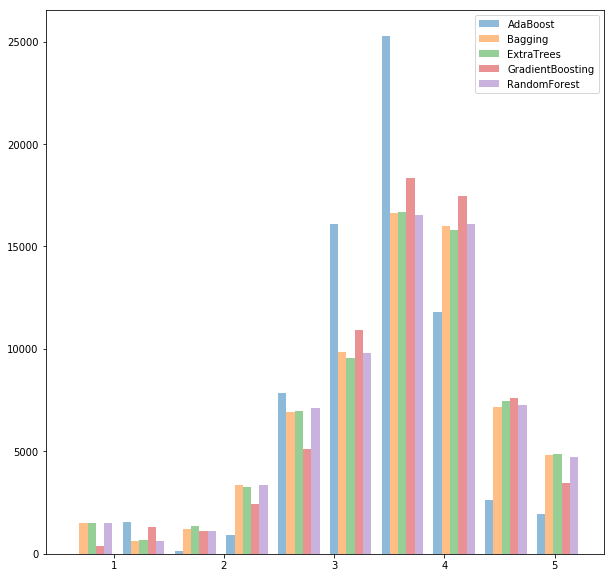

In [11]:
plt.figure(figsize=(10, 10))
plt.hist([preds_AdaBoost, preds_Bagging, preds_ExtraTrees, preds_GradientBoosting, preds_RandomForest], label=['AdaBoost', 'Bagging', 'ExtraTrees', 'GradientBoosting', 'RandomForest'], alpha=0.5)
plt.legend()
plt.show()